# VRF-System Analysis
---

## Introduction

In this notebook the usage of package `hvac.vrf_system` will be demonstrated. For this example we'll use a MITSUBISHI R2 SERIES VRF-system with outdoor unit PURY P-450 YSLM-A1 running in **heating mode**. The capacity tables taken from the manufacturer's data book were added to the example folder (see file `capacity_tables.pdf`). 

In this notebook, a single VRF system is analyzed. The `multi_vrf_systems_analysis.py` script in the example folder analyzes three VRF-systems together with respect to a given building to compare their performance and to select the VRF-system best suited for this building.

The purpose of package `hvac.vrf_system` is to determine the cooling or heating capacity and the associated input power of a VRF-system under varying operating conditions, mainly the outdoor air temperature, the indoor air setpoint temperatures of the spaces in the building, and the actual load on the VRF-system. There are also other factors that will influence the performance of a VRF-system: 
- the combination ratio of the VRF-system (i.e. the ratio of the installed total rated indoor unit capacity to the rated capacity of the outdoor unit)
- the equivalent piping length between the outdoor unit and the furthest indoor unit
- the height difference between the outdoor unit and the highest or lowest indoor unit or the height difference between the lowest and highest indoor unit in the system
- the number of defrost cycles in heating mode which depends on the outdoor air temperature

The program is largely based on the method set out in the paper ["Creating Performance Curves for Variable Refrigerant Flow Heat Pumps in EnergyPlus"](https://www.researchgate.net/publication/294891791_Creating_Performance_Curves_for_Variable_Refrigerant_Flow_Heat_Pumps_in_EnergyPlus) written by R. Raustad. However, instead of using regression analysis, linear interpolation is used for implementing the performance curves.

Using the charts and/or tables provided by the manufacturer, a number of functions can be derived that allow the calculation of the capacity and input power of a VRF-system under a given set of operating conditions:
- Function *CAPFT_fun* returns parameter *CAPFT*, the capacity ratio of the outdoor unit for a given set of indoor and outdoor air temperatures (i.e. the ratio of the available full-load capacity to the rated full-load capacity of the outdoor unit).
- Function *CR_corr_fun* returns parameter *CR_corr*, a correction factor for the outdoor unit capacity depending on the combination ratio of the VRF-system.
- Function *Leq_pipe_corr_fun* returns parameter *Leq_pipe_corr*, a correction factor for the outdoor unit capacity depending on the equivalent piping length between the outdoor unit and the furthest indoor unit in the system.
- Function *defrost_corr_fun* returns parameter *defrost_corr*, a correction factor for the outdoor unit capacity that depends on the outdoor air temperature when the VRF-system is running in heating mode.
- Function *EIRFT_fun* returns parameter *EIRFT*, the ratio of the energy input ratio under the actual set of indoor and outdoor air temperatures to the energy input ratio under the rated set of indoor and outdoor air temperatures. The energy input ratio is defined as the ratio of power input ratio to capacity ratio, with the power input ratio being defined as the ratio of actual power input to the power input at rated operating conditions.
- Function *EIRFPLR_fun* returns parameter *EIRFPLR*, the ratio of actual input power to rated input power of the outdoor unit depending on the actual part-load-ratio (PLR) of the VRF-system, when PLR is greater than or equal to the minimum PLR of the outdoor unit to which the capacity can be modulated. The PLR is the ratio of the actual load on the full-load capacity of the outdoor unit under given operating conditions. (It could be noticed that the name *EIRFPLR* was badly chosen, as it actually refers to the power input ratio instead of the energy input ratio.)
- Function *HPRTF_fun* returns parameter *HPRTF*, the heat pump runtime fraction when the PLR is less that the minimum PLR and the compressor will be cycled on/off. The heat pump runtime fraction equals 1.0 when PLR is greater than or equal to the minimum PLR of the outdoor unit.

With these functions the available full-load capacity of the outdoor unit under a given set of operating conditions can be calculated as:
```text
Q_ou = Q_rated * CAPFT * CR_corr * Leq_pipe_corr * defrost_corr
```
and the input power as:
```text
W_input = W_rated * CAPFT * EIRFT * EIRFPLR * HPRTF
```

However, the available full-load capacity of the complete VRF-system also depends on the indoor-air-temperature-dependent available capacity of the indoor units connected to the outdoor unit of the VRF-system. It is the minimum of the available full-load capacity of the outdoor unit and the sum of the available capacities of the indoor units that will determine the available full-load capacity of the VRF-system. The power input to the outdoor unit (compressor) will also be determined by the actual load on the VRF-system through the part-load-ratio (PLR).

The first step is to create a computerized model of the VRF-system using the graphs or tables from the manufacturer to define the aforementioned functions. This is done in a separate script `model_pury_P450.py` in the example folder. To create the model, the class `VRFModelCreator` is used, implemented in module `hvac.vrf_system.model.py`. With this class an instance of class `VRFModel` is created, which is then saved ("pickled") in the subfolder `models` of this example folder. You will notice that it may take some time to collect all the required manufacturer's data and enter it into a Python script.

In another module `indoor_units.py` in the example folder the indoor units of the VRF-system are created.

By calling the class method `load()` of class `VRFModel` we can load the pickled `VRFModel` instance into this notebook. By importing the function `get_indoor_units()` in this notebook from the module `indoor_units.py` in the example folder, we can retrieve the indoor units that are part of the VRF-system.

## Imports

In [31]:
import pandas as pd
from hvac import Quantity
from hvac.vrf_system import (
    VRFSystem, 
    VRFModel, 
    WorkingMode, 
    Load, 
    DesignValues, 
    find_balance_point,
    EnergyConsumption
)
from hvac.energy_estimation import (
    BinTableCreator, 
    Month, 
    TimeSegment
)
from indoor_units import get_indoor_units
from hvac.charts import LineChart
from hvac.logging import ModuleLogger

Define a shortcut alias for instantiating objects of class `Quantity`:

In [2]:
Q_ = Quantity

Turn off the logging messages from module `model` and module `vrf` in package `hvac.vrf_system` by raising the loglevel to ERROR (so, only error messages will be shown in the notebook):

In [3]:
logger = ModuleLogger.get_logger('hvac.vrf_system.model')
logger.setLevel(ModuleLogger.ERROR)

logger = ModuleLogger.get_logger('hvac.vrf_system.vrf')
logger.setLevel(ModuleLogger.ERROR)

## Creation of the VRF-System

We created the VRF-model for the VRF-system working in heating mode only. Therefore, we set parameter `vrf_model_cooling` to `None` and parameter `working_mode` to `WorkingMode.HEATING`. The VRF-model for heating is loaded from the file location where we saved the `VRFModel` instance when we ran our script `model_pury_P450.py`. We've imported above the function `get_indoor_units` from our module `indoor_units.py` that we now will call to assign the indoor units to the VRF-system.

In [4]:
pury_p_450_system = VRFSystem(
    Q_rated=Q_(56.0, 'kW'),  # rated capacity
    W_rated=Q_(12.64, 'kW'),  # rated input power
    model_size=450,
    Leq_pipe=Q_(100.0, 'm'),  # equivalent piping length
    h_pipe=Q_(0.0, 'm'),  # maximum height difference
    working_mode=WorkingMode.HEATING,
    vrf_model_cooling=None,
    vrf_model_heating=VRFModel.load('./models/pury-p450-heating.pickle'),
    indoor_units=get_indoor_units()
)

## Available Full-Load Capacity of Outdoor Unit and VRF-System 

We will first look at the available full-load capacity of the outdoor unit alone in function of outdoor air temperature. In heating mode the outdoor air temperature is actually the wet-bulb temperature at the air inlet of the outdoor unit. This implies that it is assumed that the air cooling process in the outdoor unit is fully-wet, i.e. happening along the saturation line of humid air in the psychrometric chart.

We define a range of outdoor air (wet-bulb) temperatures between -20 and including 15 °C, with a step size of 1 °C:

In [5]:
Toa_rng = Q_([Toa for Toa in range(-20, 16)], 'degC')

Next, we let the available full-load outdoor unit capacity to be calculated for each value in the outdoor air temperature range:

In [6]:
Qh_ou_rng = [
    pury_p_450_system.get_full_load_outdoor_unit_capacity(Tia_avg=None, Toa=Toa) 
    for Toa in Toa_rng
]

> **Note**<br>
> By setting parameter `Tia_avg` (the load-weighted average indoor air temperature to `None`, we tell the method `get_full_load_outdoor_unit_capacity` to calculate the load-weighted average indoor air temperature internally based on the indoor air setpoint temperature values we've associated with each indoor unit in our function `get_indoor_units` in module `indoor_units.py`. In this function all indoor units were associated with the same setpoint temperature of 23 °C, so the load-weighted average indoor air temperature will also be equal to 23 °C, regardless of the individual space loads.

The available full-load capacity of the VRF-system will however be limited to, either the available full-load capacity of the outdoor unit, or the available total capacity of the connected indoor units, whichever is smaller.

The available total capacity of connected indoor units is independent of outdoor air temperature and can be retrieved with:

In [7]:
Qh_iu_tot = pury_p_450_system.get_full_load_total_indoor_unit_capacity()
print(f"total available indoor unit capacity = {Qh_iu_tot.to('kW'):~P.3f}")

total available indoor unit capacity = 50.020 kW


The available full-load capacity of the VRF-system in function of (wet-bulb) outdoor air temperature can be retrieved with:

In [8]:
Qh_vrf_rng = [
    pury_p_450_system.get_available_capacity(Toa) 
    for Toa in Toa_rng
]

Now, we can display the available full-load outdoor unit and available full-load system capacity versus (wet-bulb) outdoor air temperature together in one chart:

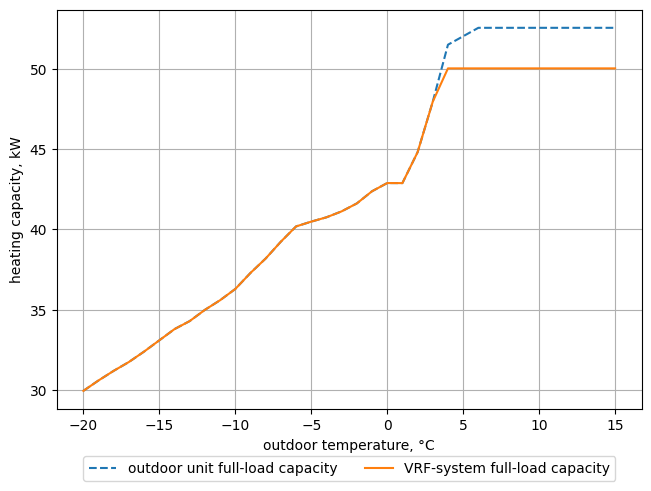

In [9]:
chart_1 = LineChart()
chart_1.add_xy_data(
    label='outdoor unit full-load capacity',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[Qh.to('kW').m for Qh in Qh_ou_rng],
    style_props={'linestyle': '--'}
)
chart_1.add_xy_data(
    label='VRF-system full-load capacity',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[Qh.to('kW').m for Qh in Qh_vrf_rng]
)
chart_1.x1.add_title('outdoor temperature, °C')
chart_1.y1.add_title('heating capacity, kW')
chart_1.add_legend()
chart_1.show()

As long as the available outdoor unit capacity is greater than the total available indoor unit capacity, the available full-load capacity of the VRF-system is determined by the smaller total indoor unit capacity.

## PLR and Input Power at Full System Load

The electrical power consumed by the compressor in the outdoor unit will depend on the (load-weighted average) indoor air temperature of the building and the outdoor air (wet-bulb) temperature at the air inlet of the outdoor unit, as well as on the part-load-ratio (PLR) of the outdoor unit. 

The PLR of the outdoor unit is the ratio of the applied system load to the available full-load outdoor unit capacity. The applied system load is the thermal power that indoor units in the building must (in heating mode) supply to or (in cooling mode) extract from the spaces, in order to maintain the desired setpoint temperature of these spaces. Should the system load exceed the available full-load system unit capacity, it could be that the PLR of the outdoor unit is still less than 1.0, as can be deduced from the figure above when outdoor air temperature is around 4 °C or more (i.e. when the available full-load outdoor unit capacity is greater than the available full-load system capacity). However, the indoor units aren't able to compensate for the building load and the desired setpoint temperature of the spaces won't be maintained.

To determine the PLR of the outdoor unit at full load as a function of outdoor air temperature, we divide the full-load system capacity range `Qh_vrf_rng` by the full-load outdoor unit capacity range `Qh_ou_rng`: 

In [10]:
PLR_fl_rng = [Qh_vrf / Qh_ou for Qh_vrf, Qh_ou in zip(Qh_vrf_rng, Qh_ou_rng)]

This can be shown in a chart:

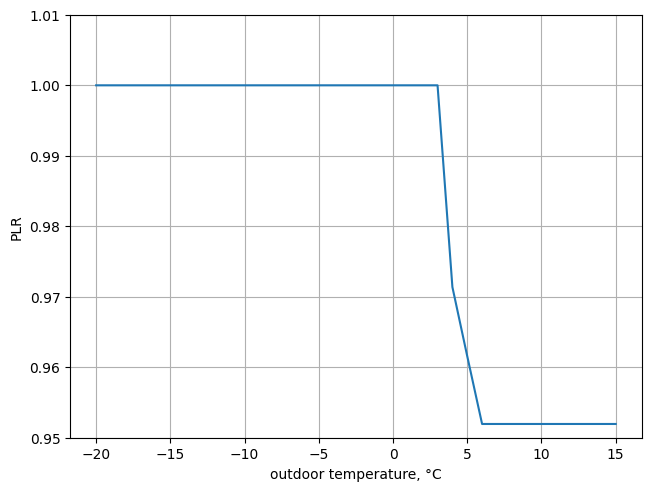

In [11]:
chart_2 = LineChart()
chart_2.add_xy_data(
    label='PLR at full-load',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[PLR.m for PLR in PLR_fl_rng]
)
chart_2.x1.add_title('outdoor temperature, °C')
chart_2.y1.add_title('PLR')
chart_2.y1.scale(0.95, 1.01, 0.01)
chart_2.show()

The input power of the outdoor unit at full system load in function of outdoor air temperature can be retrieved with:

In [12]:
W_in_fl_rng = [
    pury_p_450_system.get_input_power(Tia_avg=None, Toa=Toa, PLR=PLR)
    for Toa, PLR in zip(Toa_rng, PLR_fl_rng)
]

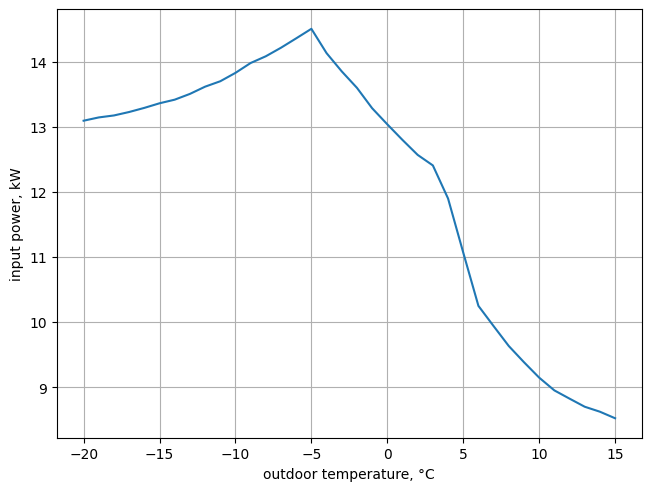

In [13]:
chart_3 = LineChart()
chart_3.add_xy_data(
    label='input power at full load',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[W_in.to('kW').m for W_in in W_in_fl_rng]
)
chart_3.x1.add_title('outdoor temperature, °C')
chart_3.y1.add_title('input power, kW')
chart_3.show()

## Coefficient of Performance (COP) at Full System Load

By definition the COP of a heat pump is the ratio of the available heating capacity ("the yield") to the input power of the compressor ("the cost"). So, to find the COP of the VRF-system in function of the outdoor air temperature, we can program: 

In [14]:
COP_fl_rng = [Qh_vrf / W_in for Qh_vrf, W_in in zip(Qh_vrf_rng, W_in_fl_rng)]

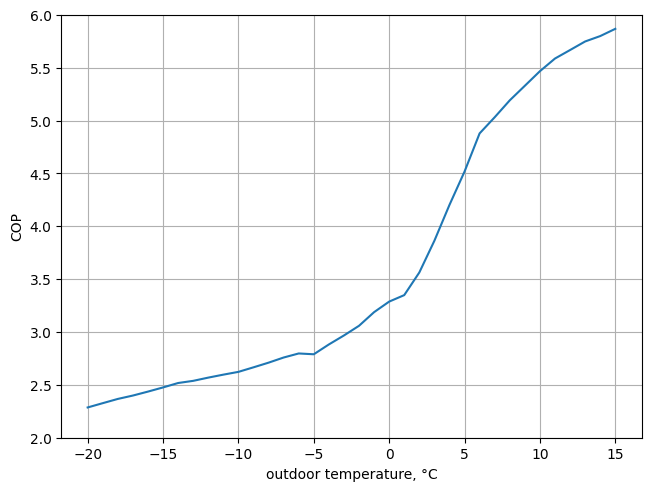

In [15]:
chart_4 = LineChart()
chart_4.add_xy_data(
    label='COP at full load',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[COP.m for COP in COP_fl_rng]
)
chart_4.x1.add_title('outdoor temperature, °C')
chart_4.y1.add_title('COP')
chart_4.y1.scale(2.0, 6.5, 0.5)
chart_4.show()

## The VRF-System Combined with a Building Load

### Building Load

Let's consider a building with a design heating load of 46.2 kW at design outdoor air temperature -7 °C and design indoor air temperature 20 °C. To represent the load of this building we will use the `Load` class from module `hvac.vrf_system.energy_estimation`:

In [16]:
building_load = Load(
    time_segment=None,
    design_values=DesignValues(
        Ql=Q_(46.2, 'kW'), 
        Tia=Q_(20, 'degC'), 
        Toa=Q_(-7, 'degC')
    ),
    Tia_avg=pury_p_450_system.Tia_avg
)

Now, we let the program calculate the building load for our range of outdoor air temperatures:

In [17]:
Ql_rng = [building_load(Toa) for Toa in Toa_rng]

### Balance Point

We can present the building load and the full-load capacity of the VRF-system together in a chart:

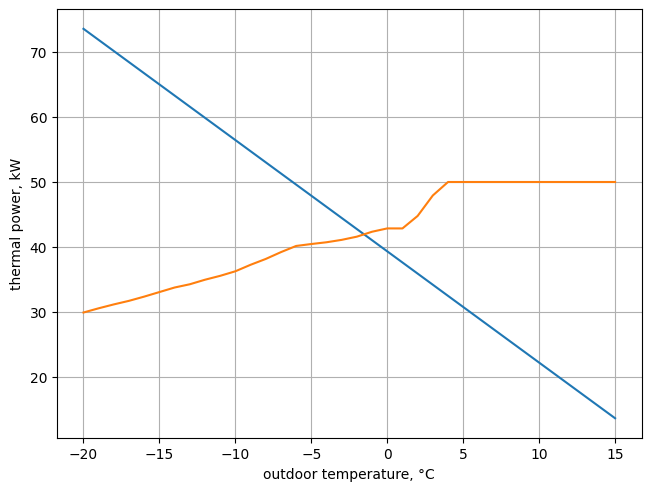

In [18]:
chart_5 = LineChart()
chart_5.add_xy_data(
    label='building load',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[Ql.to('kW').m for Ql in Ql_rng]
)
chart_5.add_xy_data(
    label='full-load system capacity',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[Qh_vrf.to('kW').m for Qh_vrf in Qh_vrf_rng]
)
chart_5.x1.add_title('outdoor temperature, °C')
chart_5.y1.add_title('thermal power, kW')
chart_5.show()

From the figure above it follows that the building load line and the full-load capacity curve of the VRF-system intersect at an outdoor air temperature between 0 and 5 °C. To find the exact outdoor air temperature where building load and system capacity balance each other, we can use the function `find_balance_point` imported above from `hvac.vrf_system`:

In [19]:
Toa_bal, Q_bal = find_balance_point(building_load, pury_p_450_system, (Toa_rng[0], Toa_rng[-1]))
print(
    f"- balance temperature = {Toa_bal.to('degC'):~P.1f}\n"
    f"- balance load = {Q_bal.to('kW'):~P.3f}"
)

- balance temperature = -1.5 °C
- balance load = 41.972 kW


At the balance point the building load is exactly balanced by the full-load system capacity. When outdoor air temperature falls below the balance temperature, the VRF-system hasn't enough capacity anymore to compensate for the building load. This means that the indoor air setpoint temperature can no longer be maintained below the balance temperature, unless auxiliary heating is provided. Above the balance temperature the full-load system capacity is greater than the building load. As the VRF-system is equipped with a variable speed compressor, the system capacity can be modulated and adapted to the smaller building load, until the minimum compressor speed has been reached. When the building load drops below the minimum system capacity, the compressor will be cycled on/off. 

### PLR and Input Power

The PLR as a function of outdoor air temperature can be determined with:

In [20]:
PLR_rng = [Ql / Qh_ou for Ql, Qh_ou in zip(Ql_rng, Qh_ou_rng)]

where `Qh_ou_rng` is the range of full-load outdoor unit capacities that we determined earlier. We can plot the PLR-range in a chart:

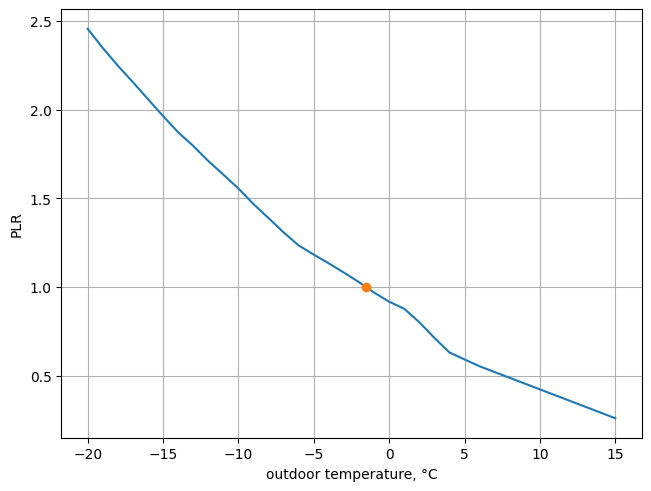

In [21]:
chart_6 = LineChart()
chart_6.add_xy_data(
    label='PLR',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[PLR.m for PLR in PLR_rng]
)
chart_6.add_xy_data(
    label='balance point',
    x1_values=[Toa_bal.to('degC').m],
    y1_values=[1.0],
    style_props={'marker': 'o', 'linestyle': 'none'}
)
chart_6.x1.add_title('outdoor temperature, °C')
chart_6.y1.add_title('PLR')
chart_6.show()

From this chart it can be seen that below the balance temperature the PLR becomes greater than 1.0, and from the previous chart it is seen that below the balance temperature the building load exceeds the available heating capacity of the VRF-system.

The question could be asked if a PLR-value greater than 1.0 makes sense when determining the input power of the outdoor unit. A PLR-value greater than 1.0 implies that the building load exceeds the outdoor unit capacity, which means that the outdoor unit cannot deliver the heating power needed to maintain the indoor air setpoint temperature of the building. 

Without auxiliary heating the indoor air temperature in the building will drop, reducing the heat loss of the building until it balances again with the full-load system capacity, which coincides with the full-load outdoor capacity for outdoor air temperatures below the balance temperature, as can be seen in the first chart of this notebook. The fact that at steady-state the load will ultimately balance the outdoor unit capacity, implies that PLR will be limited to 1.0.

If auxiliary heating is present in the building, it may be assumed that the indoor air temperature of the building will be maintained. The VRF-system will deliver its available full-load heating capacity, while the backup heating system makes up the shortfall to meet the total heating load. This also implies that PLR will be limited to 1.0.

Using the function below, we will calculate the input power of the outdoor unit versus outdoor air temperature for 3 scenarios:
1. maximum PLR restricted to 1.0 and no auxiliary heating is present
2. maximum PLR restricted to 1.0 and with auxiliary heating present
3. no PLR restriction and regardless auxiliary heating is present or not; we simply calculate PLR by dividing building load by outdoor unit capacity and apply it directly to the input-power-method of our `VRFSystem` object.

In [22]:
def calculate_input_power(PLR_restr: bool, aux_heating_present: bool = False) -> list[Quantity]:
    W_in_rng_ = []
    for Toa in Toa_rng:
        if PLR_restr and Toa < Toa_bal:
            if not aux_heating_present:
                Qh_ou = pury_p_450_system.get_full_load_outdoor_unit_capacity(None, Toa)
                Tia_avg = Qh_ou / building_load.K + Toa
                PLR = Q_(1.0, 'frac')
                W_in_rng_.append(
                    pury_p_450_system.get_input_power(Tia_avg, Toa, PLR)
                )
            else:
                PLR = Q_(1.0, 'frac')
                W_in_rng_.append(
                    pury_p_450_system.get_input_power(None, Toa, PLR)
                )
        else:
            Ql = building_load(Toa)
            Qh_ou = pury_p_450_system.get_full_load_outdoor_unit_capacity(None, Toa)
            PLR = Ql / Qh_ou
            W_in_rng_.append(
                pury_p_450_system.get_input_power(None, Toa, PLR)
            )
    return W_in_rng_

# input power with PLR restriction and no auxiliary heating
W_in_nah_rng = calculate_input_power(PLR_restr=True, aux_heating_present=False)

# input power with PLR restriction and with auxiliary heating
W_in_wah_rng = calculate_input_power(PLR_restr=True, aux_heating_present=True)

# input power without PLR restriction
W_in_npr_rng = calculate_input_power(PLR_restr=False)

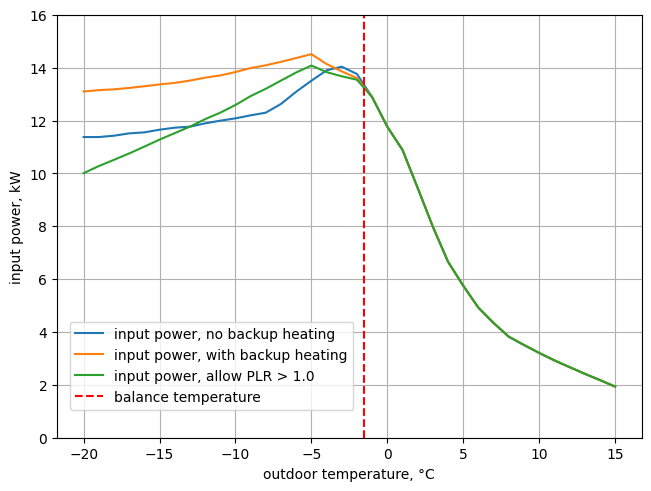

In [23]:
chart_7 = LineChart()
chart_7.add_xy_data(
    label='input power, no backup heating',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[W_in.to('kW').m for W_in in W_in_nah_rng]
)
chart_7.add_xy_data(
    label='input power, with backup heating',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[W_in.to('kW').m for W_in in W_in_wah_rng]
)
chart_7.add_xy_data(
    label='input power, allow PLR > 1.0',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[W_in.to('kW').m for W_in in W_in_npr_rng]
)
chart_7.add_xy_data(
    label='balance temperature',
    x1_values=[Toa_bal.to('degC').m] * 2,
    y1_values=[0.0, 16.0],
    style_props={'linestyle': '--', 'color': 'red'}
)
chart_7.x1.add_title('outdoor temperature, °C')
chart_7.y1.add_title('input power, kW')
chart_7.y1.scale(0, 18, 2)
chart_7.add_legend(anchor='lower left', position=(0.01, 0.05), columns=1)
chart_7.show()

### COP

As the design outdoor air temperature of the building is -7 °C, it makes sense to provide a back-up heating system for cold winter days. To calculate the COP of the VRF-system in function of outdoor air temperature, we will use the input power values from `W_in_wah_rng` and compare the actual COP with the COP at full-load of the VRF-system.

In [24]:
COP_rng = [min(Qh_vrf, Ql) / W_in for Qh_vrf, Ql, W_in in zip(Qh_vrf_rng, Ql_rng, W_in_wah_rng)]

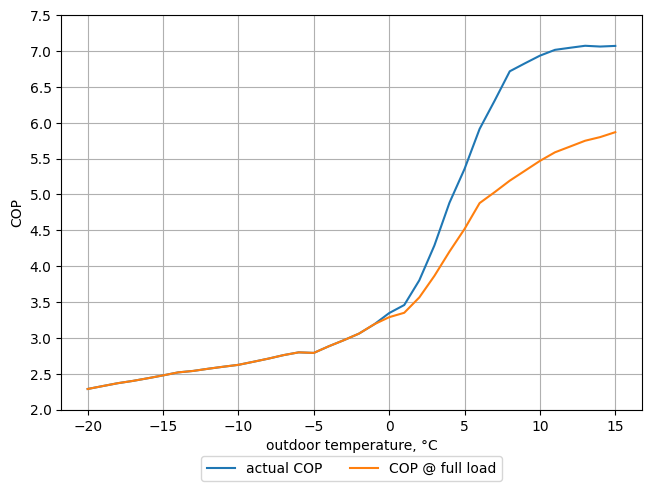

In [25]:
chart_8 = LineChart()
chart_8.add_xy_data(
    label='actual COP',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[COP.m for COP in COP_rng]
)
chart_8.add_xy_data(
    label='COP @ full load',
    x1_values=[Toa.to('degC').m for Toa in Toa_rng],
    y1_values=[COP.m for COP in COP_fl_rng]
)
chart_8.x1.add_title('outdoor temperature, °C')
chart_8.y1.add_title('COP')
chart_8.y1.scale(2.0, 8.0, 0.5)
chart_8.add_legend()
chart_8.show()

## Estimation of Energy Consumption

To estimate the energy consumption of the VRF-system and backup heating system, we will use the bin-method. For this we've already imported above the `BinTableCreator` class from module `hvac.energy_estimation`. 

To use this class we need TMY-data representative for the geographical location of the building. TMY-data can be retrieved from e.g. [JRC Photovoltaic Geographical Information System (PVGIS)](https://re.jrc.ec.europa.eu/pvg_tools/en/#TMY). The selected TMY-data can be saved as a csv-file. This file can be found in the directory `tmy` of this example folder. 

To create a bin-table we need to instantiate the `BinTableCreator` class:

In [32]:
bin_table_creator = BinTableCreator(
    file_path="./tmy/tmy_50.811_3.310_2005_2020.csv",
    date_time_column_name='time(UTC)',
    temperature_column_name='T2m',
    bin_limits=(Q_(-10, 'degC'), Q_(22, 'degC')),
    time_segments=[
        TimeSegment('0 - 7 h', (0, 7)),
        TimeSegment('7 - 18 h', (7, 18)),
        TimeSegment('18 - 24 h', (18, 24))
    ]
)

With the `BinTableCreator` instance at our disposal, we can now retrieve a bin-table (actually a Pandas `DataFrame` object) by month. We will collect the bin-tables for all the months that are part of the heating season (January, February, March, April, October, November, and December) into a single bin-table:

In [38]:
heating_season = [Month.Jan, Month.Feb, Month.Mar, Month.Apr, Month.Oct, Month.Nov, Month.Dec]
bin_table = sum(bin_table_creator.get_bin_table(m) for m in heating_season)

print(bin_table)

           0 - 7 h  7 - 18 h  18 - 24 h
(-10, -8]        0         1          0
(-8, -6]         1         0          0
(-6, -4]         9         3          1
(-4, -2]        26         9          7
(-2, 0]         92        84         53
(0, 2]         147       111         90
(2, 4]         193       205        113
(4, 6]         270       261        238
(6, 8]         233       354        204
(8, 10]        239       390        189
(10, 12]       154       350        184
(12, 14]        75       229         99
(14, 16]        41       148         45
(16, 18]         4        70         24
(18, 20]         0        24         15


A bin-table is split into time segments. Each cell contains the number of hours during a typical heating season that the outside air temperature falls within the corresponding temperature bin and during the corresponding time segment of the day. For example, between 0 and 7 o'clock (included), the outside air temperature is between 6 and 8 °C during 233 hours of a typical heating season.

Before we proceed to estimate the energy consumption of the VRF-system and the backup heating system, we need to assign a "building load", represented by the `Load` class, to each time segment of the bin-table. To keep it simple, let us assume that the building load characteristics remain unaltered during the day. 

Now, we can instantiate the class `EnergyConsumption` defined in module `hvac.vrf_system.energy_estimation` and immediately call its `estimate()` method that will return a Pandas `DataFrame` object with the estimated energy consumption of the VRF-system, and also the additional heating energy that may be needed from an auxiliary source of heat (if this source is electrical, the additional heating energy is also the amount of energy being consumed). 

In [37]:
energy_consumption = EnergyConsumption(
    bin_table=bin_table,
    loads=[building_load] * 3,
    vrf_system=pury_p_450_system
).estimate().round(decimals=3)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 800):
    print(energy_consumption)

Day Period    0 - 7 h                      7 - 18 h                    18 - 24 h                        TOTAL                    
Consumption       VRF     Aux.      Tot.        VRF    Aux.       Tot.       VRF    Aux.      Tot.        VRF     Aux.       Tot.
(-10, -8]       0.000    0.000     0.000     13.987  17.467     31.455     0.000   0.000     0.000     13.987   17.467     31.455
(-8, -6]       14.223   12.098    26.321      0.000   0.000      0.000     0.000   0.000     0.000     14.223   12.098     26.321
(-6, -4]      130.619   66.860   197.479     43.540  22.287     65.826    14.513   7.429    21.942    188.672   96.575    285.247
(-4, -2]      360.321   87.560   447.881    124.726  30.309    155.036    97.009  23.574   120.583    582.057  141.443    723.500
(-2, 0]      1185.733    0.000  1185.733   1082.626   0.000   1082.626   683.085   0.000   683.085   2951.444    0.000   2951.444
(0, 2]       1600.715    0.000  1600.715   1208.703   0.000   1208.703   980.030   0.000  